In [1]:
import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt

import torch

import torch.nn as nn

In [2]:
data = pd.read_csv('train.csv')

data = data[:10000]

data

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,66190726,Senior Optometrist Ebbe Vale,This is an excellent opportunity for a dedicat...,Ebbe Vale,UK,part_time,NaN,NaN,Healthcare & Nursing Jobs,"52,000 per year",52000,careworx.co.uk
9996,66190728,Domiciliary Optometrist Kent,Domiciliary Optometrist Kent The Company prid...,Kent,Kent,part_time,NaN,NaN,Healthcare & Nursing Jobs,"60,000 per year",60000,careworx.co.uk
9997,66190734,Optometrist Job Hastings,This is an excellent opportunity for a dedicat...,"Hastings, East Sussex",Hastings,part_time,NaN,NaN,Healthcare & Nursing Jobs,"50,000 per year",50000,careworx.co.uk
9998,66190736,Optometrist Job Doncaster,This is an excellent opportunity for a dedicat...,Doncaster,Doncaster,part_time,NaN,NaN,Healthcare & Nursing Jobs,"35,000 to 60,000 per year",47500,careworx.co.uk


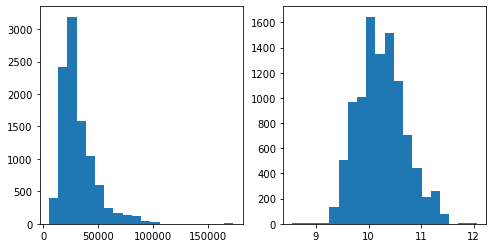

In [3]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [4]:
text_columns = ["Title", "FullDescription"]

categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]

TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN')

data.head(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,10.308986
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk,10.308986


In [5]:
import nltk

from nltk import WordPunctTokenizer

tokenizer = nltk.tokenize.WordPunctTokenizer()

# Will have Title as string of space separated tokens 
data['Title'] = data['Title'].apply(lambda x: " ".join((tokenizer.tokenize(str(x).lower()))))
# Will have FullDescription as string of space separated tokens 
data['FullDescription'] = data['FullDescription'].apply(lambda x: " ".join((tokenizer.tokenize(str(x).lower()))))

In [6]:
from collections import Counter

In [7]:
title_tokens_count = Counter(sum([i.split() for i in data['Title']], []))
descr_tokens_count = Counter(sum([i.split() for i in data['FullDescription']], []))

tokens_count       = title_tokens_count + descr_tokens_count

In [8]:
print(f'{len(tokens_count)} unique tokens')

27756 unique tokens


In [9]:
min_count = 10
tokens    = [token for token, count in tokens_count.items() if count > min_count]
# Add special tokens for unknown and padding
UNK, PAD  = "UNK", "PAD"
tokens    = [UNK, PAD] + tokens

tokens[:10]

['UNK',
 'PAD',
 'engineering',
 'systems',
 'analyst',
 'stress',
 'engineer',
 'glasgow',
 'modelling',
 'and']

In [10]:
print("Vocabulary size is", len(tokens))

Vocabulary size is 7151


In [11]:
# Toke index
token_to_idx = {token: tokens.index(token) for token in tokens}

In [12]:
UNK_IX, PAD_IX = map(token_to_idx.get, [UNK, PAD])


def as_matrix(sequences):
    sequences = list(map(tokenizer.tokenize, sequences))
    
    max_len = max(map(len, sequences))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    
    for i, seq in enumerate(sequences):
        row_idxs = [token_to_idx.get(token, UNK_IX) for token in seq]
        matrix[i, :len(row_idxs)] = row_idxs
    
    return matrix

In [13]:
as_matrix(['Hi, I am cat',
           'I like data science'])

array([[   0,   15,    0, 2041,    0],
       [   0, 1588,  302, 1453,    1]], dtype=int32)

In [14]:
k = 10

top_k_companies_names, top_k_companies_counts = zip(*Counter(data['Company']).most_common(k))

unique_top_k_companies_names = set(top_k_companies_names)

data['Company'] = data['Company'].apply(lambda comp: comp if comp in unique_top_k_companies_names else "Other")

data['Company']

0       Other
1       Other
2       Other
3       Other
4       Other
        ...  
9995      NaN
9996      NaN
9997      NaN
9998      NaN
9999      NaN
Name: Company, Length: 10000, dtype: object

In [15]:
from sklearn.feature_extraction import DictVectorizer

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)

categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [16]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index     = range(len(data_train))
data_val.index       = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  8000
Validation size =  2000


In [17]:
def make_batch(data, batch_size, title_word_dropout=0, descr_word_dropout=0):
    batch = {}
    
    batch["FullDescription"] = as_matrix(data["FullDescription"].values)
    batch["Title"] = as_matrix(data["Title"].values)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if title_word_dropout != 0:
        batch["Title"] = apply_word_dropout(batch["Title"], keep_prop= 1. - title_word_dropout)
    if descr_word_dropout !=0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], keep_prop= 1. - descr_word_dropout)
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    
    return to_tensors(batch)



def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    """
    matrix: numpy array, needed to use matrix != pad_ix mask condition
    because we dont want to set UNK to the PAD
    """
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])



def to_tensors(batch):
    batch_tensors = dict()
    for key, arr in batch.items():
        batch_tensors[key] = torch.tensor(arr)
    return batch_tensors
    


# make_batch(data, 1, title_word_dropout=0.0, descr_word_dropout=0.)

# apply_word_dropout(matrix=np.array([
#     [2, 3, 1, 1, 1],
#     [3, 4, 1, 1, 1]
# ]), keep_prop=0.8)

In [18]:
class Model(nn.Module):
    
    def __init__(self, embedding_dim=64, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        
        self.full_description_emb = nn.Embedding(n_tokens, embedding_dim)
        self.title_emb = nn.Embedding(n_tokens, embedding_dim)
        
        self.full_description_seq = nn.Sequential(
            nn.Conv1d(in_channels=embedding_dim, out_channels=16, kernel_size=3, stride=1),
            nn.Tanh()
        )
        
        self.title_seq = nn.Sequential(
            nn.Conv1d(in_channels=embedding_dim, out_channels=16, kernel_size=3, stride=1),
            nn.Tanh()
        )
        
        self.categorical_seq = nn.Linear(in_features=n_cat_features, out_features=16)
        
        self.final = nn.Linear(in_features=16 * 3, out_features=1)
    
    def forward(self, batch):
        full_description = batch["FullDescription"]
        title = batch["Title"]
        categorical = batch["Categorical"]
        
        full_description_emb = self.full_description_emb(full_description).transpose(1, 2)
        full_description_output = self.full_description_seq(full_description_emb).mean(dim=2)
        
        title_emb = self.title_emb(title).transpose(1, 2)
        title_output = self.title_seq(title_emb).mean(dim=2)
        
        categorical_output = self.categorical_seq(categorical)

        merged_output = torch.cat([full_description_output, title_output, categorical_output], dim=1)

        output = self.final(merged_output).reshape(-1)
        return output

In [19]:
def iterate_minibatches(data, batch_size=256, shuffle=True, device=torch.device('cpu'), **kwargs):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)

    for start in range(0, len(indices), batch_size):
        batch = make_batch(data.iloc[indices[start : start + batch_size]], batch_size=batch_size, **kwargs)
        yield batch

In [20]:
import tqdm

BATCH_SIZE = 16
EPOCHS = 20
DEVICE = torch.device('cpu')


def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [21]:
model     = Model()
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

In [22]:
for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch % 10 == 0: 
        print_metrics(model, data_val)

epoch: 0


  0%|          | 0/500 [00:00<?, ?it/s]

 results:
Mean square error: 1.14527
Mean absolute error: 0.82701
epoch: 1


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 2


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 3


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 4


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 5


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 6


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 7


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 8


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 9


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 10


  0%|          | 0/500 [00:00<?, ?it/s]

 results:
Mean square error: 0.17011
Mean absolute error: 0.31508
epoch: 11


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 12


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 13


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 14


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 15


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 16


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 17


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 18


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 19


  0%|          | 0/500 [00:00<?, ?it/s]

In [26]:
def explain(model, sample, col_name, sensitivity=1):
    sample_col_tokens = [tokens[token_to_idx.get(tok, 0)] for tok in sample[col_name].split()]

    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens)))
    data_full           = pd.DataFrame([sample] * (len(sample_col_tokens)))

    # Since we want to try to drop each word we will have
    # to set 'number of words' times UNC to different position
    batch_size = len(data_full)

    text_col_idx = data_full.columns.get_loc(col_name)
    text = data_drop_one_token.iloc[0, text_col_idx].split()

    for i in range(batch_size):
        data_drop_one_token.iloc[i, text_col_idx] = ' '.join([UNK if j == i else t for j, t in enumerate(text)])

    data_drop_one_token_batch  = make_batch(data_drop_one_token, batch_size)
    data_drop_one_token_output = model.forward(data_drop_one_token_batch)


    data_baseline_batch = make_batch(data_full, batch_size)
    data_baseline = model.forward(data_baseline_batch)

    # if diff < 0 it means that without word, the price is higher,
    # so probably its red flag, lets make it red
    # and if diff > 0 it means that without price is lower
    diff = (data_baseline - data_drop_one_token_output).detach() * sensitivity
    return list(zip(text, diff))
    
# explain(model=model, sample=data.iloc[2], col_name='Title')

In [27]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"):
    
    def get_color_hex(weight):
        # weight here is out diff so when its < 0 then it means without this word
        # price would be higher so its reg flag to delete
        # Sigmoid kind of
        rgba = cmap(1. / (1 + np.exp(weight.detach().numpy())), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html

In [36]:
explain_title = explain(model=model, sensitivity=1, sample=data.iloc[23], col_name='Title')
draw_html([(text, diff) for text, diff in explain_title]);

explain_descr = explain(model=model, sensitivity=10, sample=data.iloc[23], col_name='FullDescription')
draw_html([(text, diff) for text, diff in explain_descr]);

control and instrumentation engineer

control and instrumentation engineer / c reading . our client is seeking applications from experienced c control and instrumentation engineer / c degree ( or equivalent ) in electrical , electronic or control and instrumentation engineering or other relevant discipline . chartered engineer . able to demonstrate sound technical experience . a sufficient and appropriate level of building services and controls experience gained within a client organisation , engineering consultancy or equipment supplier . project management , including controls , planning and estimating and preparation of deliverable / work package . desirable working within a multidiscipline engineering team and having a general appreciation of other disciplines constraints and requirements . nuclear safety case issues and nii site licence conditions . building management systems . fire detection and alarms . telecoms . ups . experience of the nuclear industry . experience of iee wiring regulations 17th edition bs **** experience of transmission (**** kv ) electrical plant and configuration design . experience of distribution ( up to **** kv ) electrical plant and configuration design . experience of protection and control design at transmission and distribution voltages . the individual control and instrumentation engineer a confident and professional manner . excellent communication skills . ability to use initiative and demonstrate creativity . self motivated and committed to further study . ability to work within a team . responsibilities responsible for providing technical input into the control and instrumentation , and potentially electrical , design aspects of substation refurbishment / rekit projects and leading electrical / control aspects of major infrastructure projects from system studies and investment appraisals through to detailed design . liaison with clients , suppliers and contractors . provide technical input into the specification , selection and justification of relevant equipment . generation of front end engineering design packages . provide technical input into the relevant equipment assessment and justification reports . production of commissioning procedures . production of technical specifications . control and instrumentation engineer / c location reading , berkshire